Gaussian process latent variable model on NHANES using Pyro
source:
https://pyro.ai/examples/gplvm.html

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.nn import Parameter

import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
import pyro.ops.stats as stats

smoke_test = ('CI' in os.environ)  # ignore; used to check code integrity in the Pyro repo
assert pyro.__version__.startswith('1.8.0')
pyro.set_rng_seed(1)

In [2]:
df = pd.read_csv('/Users/victorlhoste/Desktop/Local_PhD/NHANES/Data/data_pyro.csv', index_col=0)
df.index=df[["age_group"]].values.flatten()
df=df[["height","bmi","WHtR","hba1c","hdl","non_hdl","sbp","dbp","eGFR"]]
print("Data shape: {}\n{}\n".format(df.shape, "-" * 21))
print("Data labels: {}\n{}\n".format(df.index.unique().tolist(), "-" * 86))
print("Show a small subset of the data:")
df.head()

Data shape: (58876, 9)
---------------------

Data labels: ['Young', 'Middage', 'Old']
--------------------------------------------------------------------------------------

Show a small subset of the data:


,height,bmi,WHtR,hba1c,hdl,non_hdl,sbp,dbp,eGFR
Young,178.8,25.524376,0.496644,5.3,0.9842,5.9570,117,59,95.625163
Young,162.2,23.433188,0.557953,4.6,1.4245,2.7195,130,88,114.670330
Middage,156.9,27.642813,0.570427,5.3,1.7094,4.4030,134,75,87.324169
Young,177.4,29.392363,0.576099,4.6,1.1137,4.7138,135,94,77.957926
Middage,168.2,24.954721,0.558859,9.1,1.3209,5.4131,121,69,79.104629


In [3]:
data = torch.tensor(df.values, dtype=torch.get_default_dtype())
# we need to transpose data to correct its shape
y = data.t()

In [4]:

# we setup the mean of our prior over X
X_prior_mean = torch.zeros(y.size(1), 2)  
#X_prior_mean[:, 0] = time

In [5]:
kernel = gp.kernels.RBF(input_dim=2, lengthscale=torch.ones(2))

# we clone here so that we don't change our prior during the course of training
X = Parameter(X_prior_mean.clone())

# we will use SparseGPRegression model with num_inducing=32;
# initial values for Xu are sampled randomly from X_prior_mean
Xu = stats.resample(X_prior_mean.clone(), 32)
gplvm = gp.models.SparseGPRegression(X, y, kernel, Xu, noise=torch.tensor(0.01), jitter=1e-5)


In [6]:
gplvm.X = pyro.nn.PyroSample(dist.Normal(X_prior_mean, 0.1).to_event())
gplvm.autoguide("X", dist.Normal)

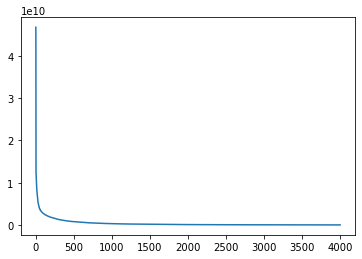

In [7]:

losses = gp.util.train(gplvm, num_steps=4000)

# let's plot the loss curve after 4000 steps of training
plt.plot(losses)
plt.show()

In [8]:
gplvm.mode = "guide"
X = gplvm.X

Visualization of the results

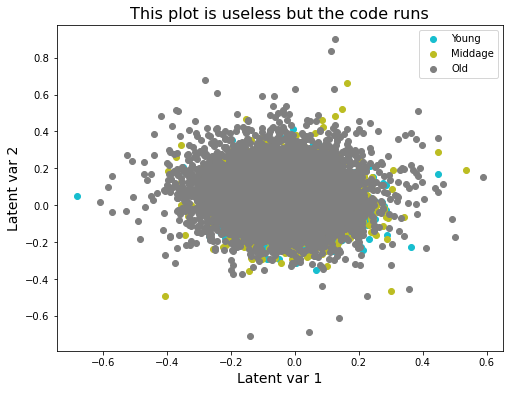

In [12]:
plt.figure(figsize=(8, 6))
colors = plt.get_cmap("tab10").colors[::-1]
labels = df.index.unique()

X = gplvm.X_loc.detach().numpy()
for i, label in enumerate(labels):
    X_i = X[df.index == label]
    plt.scatter(X_i[:, 0], X_i[:, 1], c=[colors[i]], label=label)

plt.legend()
plt.xlabel("Latent var 1", fontsize=14)
plt.ylabel("Latent var 2", fontsize=14)
plt.title("This plot is useless but the code runs", fontsize=16)
plt.show()

## The above was with continous latent variables
In my case I want the latent variables aka my clusters to be categorical, that is what I am going to try below

In [15]:
# I think the correct thing is to use MultiClass model (not sure though)
# Actually no this a type of likelihood

#gplvm = pyro.MultiClass(num_classes=3)



tensor([[-1.0156,  0.2566],
        [ 0.2093,  0.4608],
        [-0.5541,  1.7249],
        ...,
        [-0.2266, -0.0107],
        [-0.6825,  0.6633],
        [-0.3130,  0.7631]], grad_fn=<AddBackward0>)